In [1]:
import argparse
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear, LazyLinear, Sequential, BatchNorm1d, ReLU

import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero, LightGCN

/Users/ioannisathanasiou/diploma/environ/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pathlib
import os
import sys
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))
from utils.Neo4jMovieLensMetaData import Neo4jMovieLensMetaData
from utils.gnn_simple import Model
from utils.visualize import plot_loss, plot_test
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4jMetaData')
# dataset = Neo4jMovieLensMetaData(
#     path,
#     model_name='all-MiniLM-L6-v2',
#     database_url="bolt://localhost:7687",
#     database_username="neo4j",
#     database_password="admin",
#     force_pre_process=True,
#     force_db_restore=False,
#     text_features=["title", "original_title"],
#     list_features=[],
#     fastRP_features=[],
#     numeric_features=[],
# )

path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLens')
dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

In [5]:
data = dataset[0].to(device)
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes
# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

In [6]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.15,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

In [7]:
data

HeteroData(
  movie={ x=[9742, 404] },
  user={ x=[610, 610] },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100836] }
)

In [8]:
import torch
from torch import Tensor
from torch.nn import Linear, LazyLinear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv, TransformerConv, GraphConv, GINConv, GINEConv, to_hetero, LGConv
from torch_geometric.nn.models import GIN, GraphSAGE
from torch_geometric.nn.aggr import MultiAggregation
from typing import Union
from torch_geometric.typing import Adj, OptPairTensor, Size

layers = {
    "SAGE": SAGEConv,
    "GAT": GATv2Conv,
    "GCN": GCNConv,
    "Transformer": TransformerConv,
    "GraphConv": GraphConv,
    "GIN": GINConv,
    "GINE": GINEConv,
    "LightGCN": LGConv,
}


class GNNEncoder(torch.nn.Module):
    def __init__(self, layer_name="SAGE", num_layers=4, in_channels=-1, hidden_channels=32, out_channels=32, dropout=0.1, skip_connections=True, encoder_aggr=[]):
        assert num_layers >= 2
        super().__init__()
        self.dropout = dropout
        self.num_layers = num_layers
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.dropout = dropout
        self.skip_connections = skip_connections
        self.layer = layers.get(layer_name) or SAGEConv
        self.layer_name = layer_name
        print(self.layer_name)
        
        self.aggr = None
        if encoder_aggr:
            if isinstance(encoder_aggr, str):
                self.aggr = encoder_aggr
            if len(encoder_aggr) == 1:
                self.aggr = encoder_aggr[0]
            if len(encoder_aggr) > 1:
                self.aggr = MultiAggregation(encoder_aggr)
        
        print("Aggregation:", self.aggr)

        if self.layer_name != "LightGCN":
            first_layer_args = {
                "in_channels": self.in_channels,
                "out_channels": self.hidden_channels,
                # "aggr": self.aggr,
                # **encoder_extra_config,
            }
            hidden_layer_args = {
                "in_channels": self.hidden_channels,
                "out_channels": self.hidden_channels,
                # "aggr": self.aggr,
                # **encoder_extra_config,
            }
            last_layer_args = {
                "in_channels": self.hidden_channels,
                "out_channels": self.out_channels,
                # "aggr": self.aggr,
                # **encoder_extra_config,
            }
            if self.aggr:
                first_layer_args["aggr"] = self.aggr
                hidden_layer_args["aggr"] = self.aggr
                last_layer_args["aggr"] = self.aggr
        else:
            first_layer_args = {}
            hidden_layer_args = {}
            last_layer_args = {}

        if layer_name in ["GCN", "GAT"]:
            first_layer_args["add_self_loops"] = False
            hidden_layer_args["add_self_loops"] = False
            last_layer_args["add_self_loops"] = False
        
        if self.layer_name == "GIN" or self.layer_name == "GINE":
            del hidden_layer_args["in_channels"]
            del hidden_layer_args["out_channels"]
            # hidden_layer_args["train_eps"] = True
            hidden_layer_args["nn"] = Sequential(
                Linear(hidden_channels, hidden_channels),
                BatchNorm1d(hidden_channels),
                ReLU(),
                Linear(hidden_channels, hidden_channels),
                BatchNorm1d(hidden_channels),
                ReLU(),
                Linear(hidden_channels, hidden_channels),
                BatchNorm1d(hidden_channels),
                ReLU(),
                Linear(hidden_channels, hidden_channels),
                ReLU()
            )

            del last_layer_args["in_channels"]
            del last_layer_args["out_channels"]
            # last_layer_args["train_eps"] = True
            last_layer_args["nn"] = Sequential(
                Linear(hidden_channels, hidden_channels),
                BatchNorm1d(hidden_channels),
                ReLU(),
                Linear(hidden_channels, hidden_channels),
                BatchNorm1d(hidden_channels),
                ReLU(),
                Linear(hidden_channels, hidden_channels),
                BatchNorm1d(hidden_channels),
                ReLU(),
                Linear(hidden_channels, out_channels),
                ReLU()
            )

        self.convs = torch.nn.ModuleList()
        if self.layer_name == "GIN":
            self.convs.append(SAGEConv(**first_layer_args))
        else:
            self.convs.append(self.layer(**first_layer_args))
        for _ in range(self.num_layers-2):
            self.convs.append(self.layer(**hidden_layer_args))
        self.convs.append(self.layer(**last_layer_args))

    def forward(self, x, edge_index):
        prev_x = None
        for i in range(len(self.convs)-1):
            prev_x = x
            x = self.convs[i](x, edge_index)
            # x = self.convs[i](x, edge_index, conv_index=i)
            if i > 0 and self.skip_connections:
                x = x + prev_x
            x = x.relu()
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers):
        assert num_layers >= 2
        super().__init__()
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels
        self.layers = torch.nn.ModuleList()

        self.layers.append(LazyLinear(self.hidden_channels))
        for _ in range(self.num_layers-2):
            self.layers.append(
                Linear(self.hidden_channels, self.hidden_channels))
        self.layers.append(Linear(self.hidden_channels, 1))

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        user_embeddings = z_dict['user'][row]
        movie_embeddings = z_dict['movie'][col]
        z = torch.cat([user_embeddings, movie_embeddings], dim=-1)
        for i in range(self.num_layers-1):
            z = self.layers[i](z).relu()
        z = self.layers[self.num_layers-1](z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, data, in_channels=-1, hidden_channels=32, out_channels=32, encoder_num_layers=5, decoder_num_layers=4, layer_name="SAGE", encoder_dropout=0.1, encoder_skip_connections=True, encoder_aggr=[]):
        super().__init__()
        self.encoder = GNNEncoder(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            layer_name=layer_name,
            num_layers=encoder_num_layers,
            dropout=encoder_dropout,
            skip_connections=encoder_skip_connections,
            encoder_aggr=encoder_aggr,
        )
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(
            hidden_channels,
            num_layers=decoder_num_layers
        )

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [9]:
# model = Model(data, layer_name="SAGE", hidden_channels=32, encoder_num_layers=4, decoder_num_layers=4, encoder_skip_connections=True, encoder_aggr=["mean"])
model = Model(
    data,
    layer_name="SAGE",
    encoder_num_layers=4,
    encoder_dropout=0.1,
    encoder_skip_connections=True,
    decoder_num_layers=12,
    hidden_channels=16,
    out_channels=16,
)
# model = LightGCN(num_nodes=data.num_nodes, embedding_dim=32, num_layers=3)
lr = 0.016
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# weight = torch.bincount(train_data['user', 'movie'].edge_label)
# weight = weight.max() / weight
weight = None
def weighted_rmse_loss(pred, target, weight=None):
    # weight = 1. if weight is None else weight[target].to(pred.dtype)
    weight = 1.
    # return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

SAGE
Aggregation: None


/Users/ioannisathanasiou/diploma/environ/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
def train(log=False):
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
            train_data['user', 'movie'].edge_label_index)
    # print(pred[:10])
    target = train_data['user', 'movie'].edge_label

    loss = weighted_rmse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data, log=False):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
            data['user', 'movie'].edge_label_index)
    # print(pred[:10])
    # pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    # mae = F.l1_loss(pred, target)
    return float(rmse)

# early_stopper = EarlyStopper(patience=100, min_delta=0.1)
epochs = 100
losses = []
for epoch in range(1, epochs+1):
    loss = train(log=not(epoch%20))
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data, log=not(epoch%20))
    losses.append((loss, train_rmse, val_rmse, test_rmse))
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
        f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
    # if epoch > 50 and early_stopper.early_stop(val_rmse):
    #     print("Early stopping...")
    #     break

last_losses = losses[-1]
losses = losses + [last_losses] * (epochs - len(losses))
losses_ = {"SAGE": losses}

Epoch: 001, Loss: 12.7246, Train: 3.5017, Val: 3.5225, Test: 3.4977
Epoch: 002, Loss: 12.2619, Train: 3.4433, Val: 3.4640, Test: 3.4393
Epoch: 003, Loss: 11.8560, Train: 3.3886, Val: 3.4093, Test: 3.3846
Epoch: 004, Loss: 11.4825, Train: 3.3275, Val: 3.3482, Test: 3.3236
Epoch: 005, Loss: 11.0723, Train: 3.2339, Val: 3.2547, Test: 3.2304
Epoch: 006, Loss: 10.4574, Train: 3.0209, Val: 3.0446, Test: 3.0195
Epoch: 007, Loss: 9.1312, Train: 2.3741, Val: 2.3949, Test: 2.3709
Epoch: 008, Loss: 5.6196, Train: 1.2489, Val: 1.2196, Test: 1.2363
Epoch: 009, Loss: 1.5331, Train: 1.4953, Val: 1.4405, Test: 1.4859
Epoch: 010, Loss: 2.2618, Train: 1.4276, Val: 1.4466, Test: 1.4238
Epoch: 011, Loss: 1.9990, Train: 1.6949, Val: 1.7323, Test: 1.7012
Epoch: 012, Loss: 2.8754, Train: 1.5543, Val: 1.5937, Test: 1.5779
Epoch: 013, Loss: 2.4812, Train: 1.1740, Val: 1.2023, Test: 1.1885
Epoch: 014, Loss: 1.3930, Train: 1.3363, Val: 1.2914, Test: 1.3145
Epoch: 015, Loss: 1.8516, Train: 1.3053, Val: 1.3054, Te

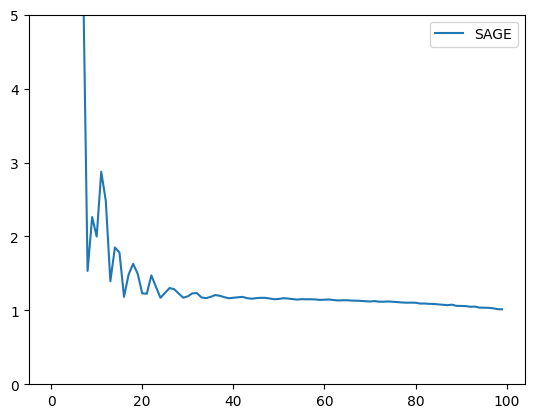

In [11]:
plot_loss(losses_, ylim=5)

<BarContainer object of 22 artists>

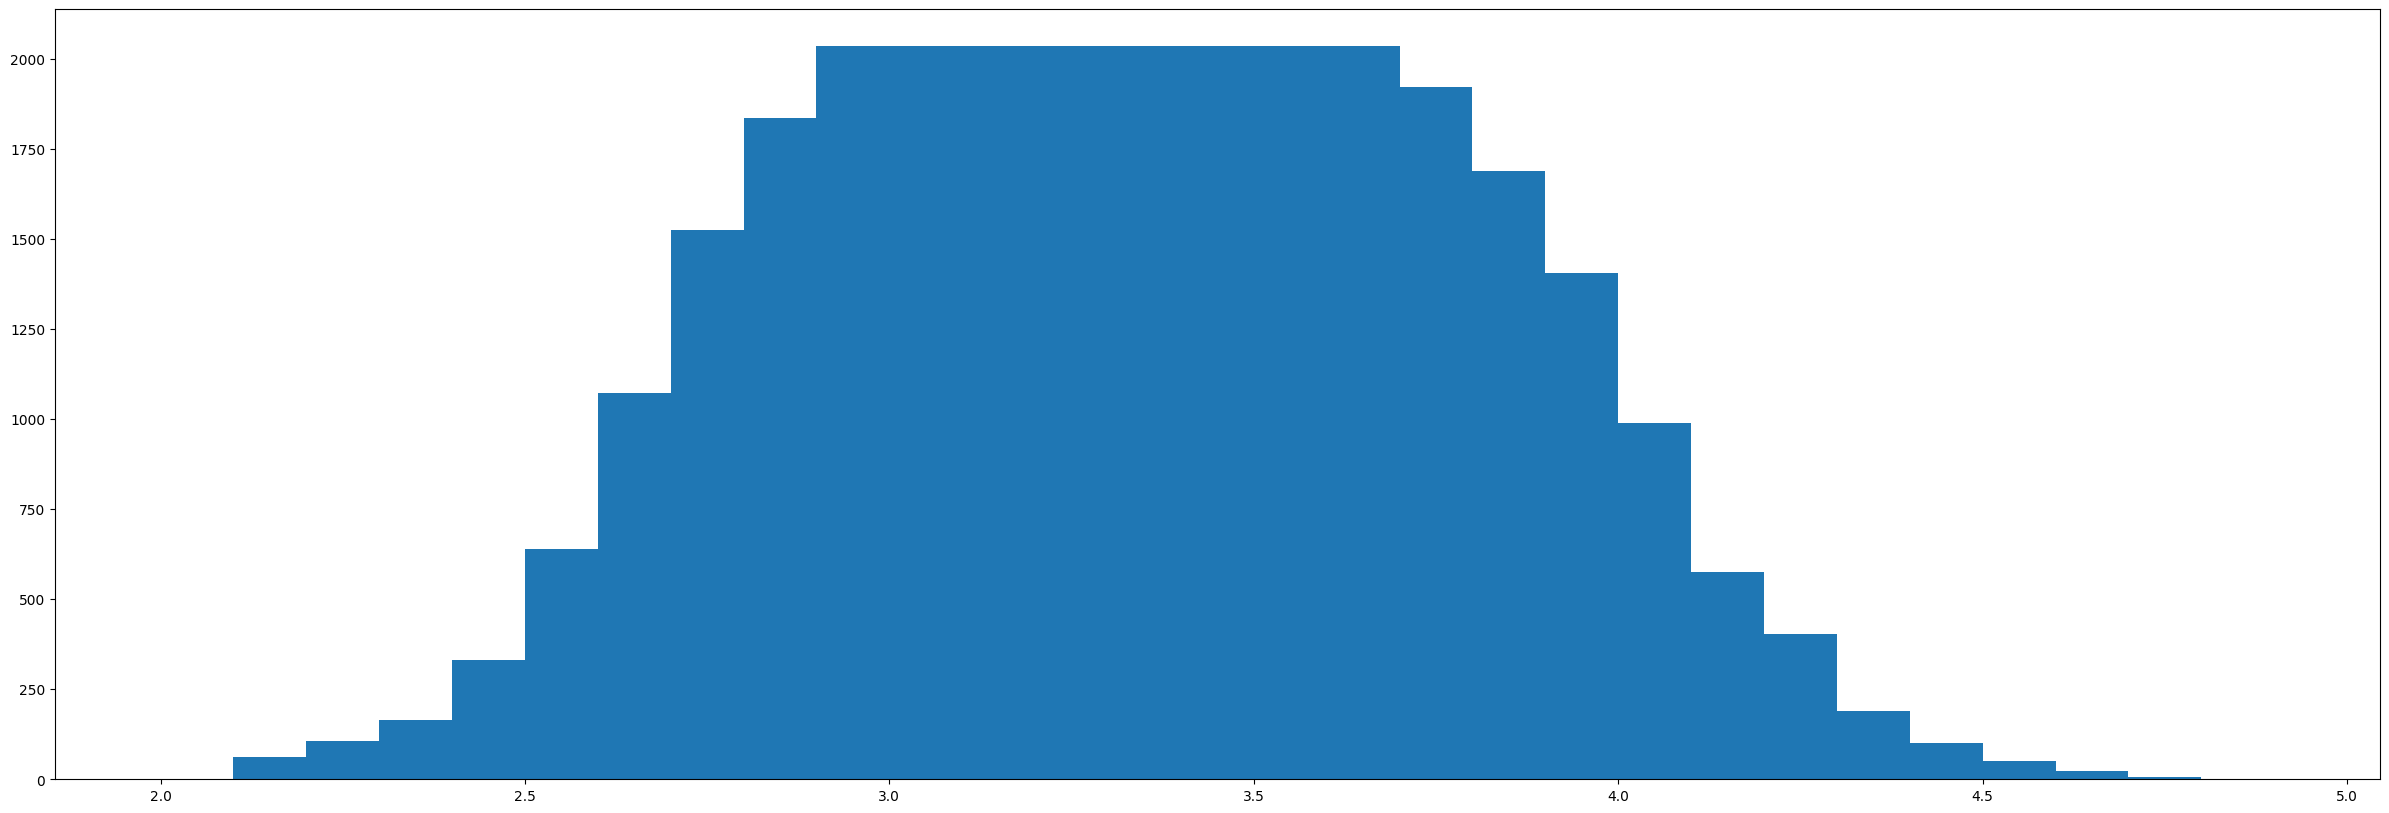

In [12]:
pred = model(test_data.x_dict, test_data.edge_index_dict, test_data["user", "movie"].edge_label_index)
ratings = pred.detach().numpy()
# dummy way but never mind
def get_group(i):
    if i<0.25:
        return 0
    elif i<0.75:
        return 0.5
    elif i < 1.25:
        return 1
    elif i < 1.75:
        return 1.5
    elif i < 2.25:
        return 2
    elif i < 2.75:
        return 2.5
    elif i < 3.25:
        return 3
    elif i < 3.75:
        return 3.5
    elif i < 4.5:
        return 4
    else:
        return 5
counters = defaultdict(int)
for rating in ratings:
    counters[round(rating, 1)] += 1
plt.bar(counters.keys(), counters.values())

In [13]:
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig, \
    HeteroExplanation, \
    CaptumExplainer, DummyExplainer, PGExplainer, AttentionExplainer

#### Dummy explainer

In [14]:
explainer = Explainer(
    model=model,
    algorithm=DummyExplainer(),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
)

In [15]:
edge_label_index = train_data['user', 'movie'].edge_label_index[:, 0]

In [16]:
edge_label_index

tensor([ 386, 4493])

In [17]:
train_data[("user", "rates", "movie")].edge_label_index

tensor([[ 386,   11,  134,  ...,  559,  562,   38],
        [4493,  644, 2437,  ...,  520, 8924, 1187]])

In [18]:
explanation = explainer(
    # x={
    #     "movie": train_data["movie"],
    #     "user": train_data["user"]
    # },
    # edge_index=train_data[("user", "rates", "movie")].edge_index,
    
    edge_index=train_data.edge_index_dict,
    
    # edge_index=train_data[("user", "rates", "movie")].edge_index,
    
    x=train_data.x_dict,
    
    # edge_index_dict=train_data.edge_index_dict,
    
    # edge_label_index=train_data['user', 'movie'].edge_label_index,
    edge_label_index=edge_label_index,
    
    # edge_index=train_data.edge_index_dict[('user', 'rates', 'movie')],
    # edge_label_index=train_data,
    
    target=None
)

In [19]:
explanation.get_explanation_subgraph()

HeteroExplanation(
  prediction=[1],
  target=[1],
  edge_label_index=[2],
  movie={
    node_mask=[9742, 404],
    x=[9742, 404]
  },
  user={
    node_mask=[610, 610],
    x=[610, 610]
  },
  (user, rates, movie)={
    edge_mask=[80670],
    edge_index=[2, 80670]
  },
  (movie, rev_rates, user)={
    edge_mask=[80670],
    edge_index=[2, 80670]
  }
)

In [20]:
train_data

HeteroData(
  movie={ x=[9742, 404] },
  user={ x=[610, 610] },
  (user, rates, movie)={
    edge_index=[2, 80670],
    edge_label=[80670],
    edge_label_index=[2, 80670]
  },
  (movie, rev_rates, user)={ edge_index=[2, 80670] }
)

In [21]:
explanation.get_explanation_subgraph()

HeteroExplanation(
  prediction=[1],
  target=[1],
  edge_label_index=[2],
  movie={
    node_mask=[9742, 404],
    x=[9742, 404]
  },
  user={
    node_mask=[610, 610],
    x=[610, 610]
  },
  (user, rates, movie)={
    edge_mask=[80670],
    edge_index=[2, 80670]
  },
  (movie, rev_rates, user)={
    edge_mask=[80670],
    edge_index=[2, 80670]
  }
)

In [22]:
explanation.get_explanation_subgraph().prediction

tensor([3.1055])

In [23]:
explanation.get_explanation_subgraph().target

tensor([3.1055])

In [24]:
explanation.get_complement_subgraph()

HeteroExplanation(
  prediction=[1],
  target=[1],
  edge_label_index=[2],
  movie={
    node_mask=[0, 404],
    x=[0, 404]
  },
  user={
    node_mask=[0, 610],
    x=[0, 610]
  },
  (user, rates, movie)={
    edge_mask=[0],
    edge_index=[2, 0]
  },
  (movie, rev_rates, user)={
    edge_mask=[0],
    edge_index=[2, 0]
  }
)

In [25]:
edge_label_index

tensor([ 386, 4493])

#### GNN explainer

In [24]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=10),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
)

In [25]:
explanation = explainer(
    # x={
    #     "movie": train_data["movie"],
    #     "user": train_data["user"]
    # },
    # edge_index=train_data[("user", "rates", "movie")].edge_index,
    
    edge_index=train_data.edge_index_dict,
    
    # edge_index=train_data[("user", "rates", "movie")].edge_index,
    
    x=train_data.x_dict,
    
    # edge_index_dict=train_data.edge_index_dict,
    
    edge_label_index=train_data['user', 'movie'].edge_label_index,
    
    # edge_index=train_data.edge_index_dict[('user', 'rates', 'movie')],
    # edge_label_index=train_data,
    
    target=None
)

ValueError: Heterogeneous graphs not yet supported in 'GNNExplainer'

In [ ]:
explanation.get_explanation_subgraph().visualize_graph()

AttributeError: 'HeteroExplanation' has no attribute 'visualize_graph'

#### Captum explainer

In [45]:
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer(attribution_method="IntegratedGradients"),
    explanation_type='model',
    # node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
)

In [46]:
explanation = explainer(
    # x={
    #     "movie": train_data["movie"],
    #     "user": train_data["user"]
    # },
    # edge_index=train_data[("user", "rates", "movie")].edge_index,
    
    edge_index=train_data.edge_index_dict,
    
    # edge_index=train_data[("user", "rates", "movie")].edge_index,
    
    x=train_data.x_dict,
    
    # edge_index_dict=train_data.edge_index_dict,
    
    edge_label_index=train_data['user', 'movie'].edge_label_index,
    
    # edge_index=train_data.edge_index_dict[('user', 'rates', 'movie')],
    # edge_label_index=train_data,
    
    target=None
)

IndexError: The shape of the mask [131903] at index 0 does not match the shape of the indexed tensor [2, 131903] at index 0

In [48]:
explanation.get_explanation_subgraph()

HeteroExplanation(
  prediction=[131903],
  target=[131903],
  edge_label_index=[2, 131903],
  movie={
    node_mask=[2055, 768],
    x=[2055, 768]
  },
  user={
    node_mask=[4633, 4633],
    x=[4633, 4633]
  },
  (user, rates, movie)={
    edge_mask=[131903],
    edge_index=[2, 131903]
  },
  (movie, rev_rates, user)={
    edge_mask=[131903],
    edge_index=[2, 131903]
  }
)